In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [12]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('VCB-Historical-Data.csv')
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df1=df.reset_index()['Price']

In [14]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [15]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [17]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [18]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [19]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [20]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\Windows 10\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=20,batch_size=64,verbose=1)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.1585 - val_loss: 0.0110
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0159 - val_loss: 0.0152
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0080 - val_loss: 0.0027
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025 - val_loss: 0.0039
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0

In [22]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [23]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [24]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 48689.43578015478
Testing RMSE: 63986.183519008824


In [31]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=66
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1,n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


ValueError: cannot reshape array of size 66 into shape (1,100,1)

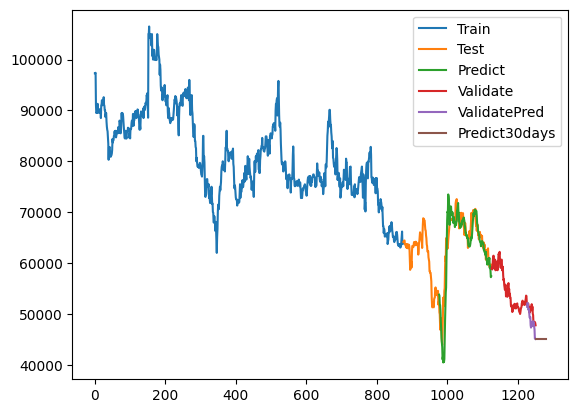

In [30]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()